In [8]:
# Out-of-Tune Instrument Detection using VGGish & EfficientNet

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import joblib
import librosa
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D


In [9]:
# ===== CONFIG =====
AUDIO_DIR = "C:/Users/saisa/Downloads/mixed_out_of_tune_samples/mixed_out_of_tune_samples"
LABELS_CSV = os.path.join(AUDIO_DIR, "labels.csv")
SAMPLE_RATE = 16000
DURATION_SEC = 4.0
N_MELS = 64
HOP_LENGTH = 256


# ===== MEL-SPECTROGRAM EXTRACTION =====
def extract_melspec(wav_path, n_mels=N_MELS, hop_length=HOP_LENGTH):
    y, _ = librosa.load(wav_path, sr=SAMPLE_RATE, mono=True)
    y = librosa.util.fix_length(y, size=int(SAMPLE_RATE * DURATION_SEC))
    S = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=n_mels, hop_length=hop_length)
    S_db = librosa.power_to_db(S, ref=np.max)
    return np.mean(S_db, axis=1)  # (n_mels,)

# ===== LOAD LABELS =====
df = pd.read_csv(LABELS_CSV)
df['filename'] = df['filename'].str.strip()
df['out_of_tune'] = df['out_of_tune'].astype(str).str.strip()

filepaths = [os.path.join(AUDIO_DIR, fname) for fname in df['filename']]
labels = df['out_of_tune'].values

In [10]:
# ===== ENCODE LABELS =====
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)
joblib.dump(label_encoder, 'label_encoder.joblib')

# ===== EXTRACT MEL FEATURES =====
X = np.stack([extract_melspec(fp) for fp in filepaths])  # Shape: (N, 64)
X = np.expand_dims(X, axis=-1)  # Shape: (N, 64, 1) → for CNN input
y = one_hot_labels

In [11]:
# ===== FILTER CLASSES WITH ≥5 SAMPLES =====
class_indices = np.argmax(y, axis=1)
(unique, counts) = np.unique(class_indices, return_counts=True)
valid_classes = unique[counts >= 5]
valid_indices = [i for i, cls in enumerate(class_indices) if cls in valid_classes]

X = X[valid_indices]
y = y[valid_indices]
class_indices = np.argmax(y, axis=1)

if len(X) == 0:
    raise ValueError("No valid samples left after filtering. Try reducing the min sample threshold.")

# ===== TRAIN TEST SPLIT =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=class_indices, test_size=0.2, random_state=42)

In [12]:
from tensorflow.keras import backend as K
K.clear_session()

# ===== 1D CNN MODEL FOR AUDIO FEATURES =====
input_layer = Input(shape=(64, 1))

x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = GlobalAveragePooling1D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(y.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 64, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 156)            │        40,092 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,076 (383.11 KB)

 Trainable params: 98,076 (383.11 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# ===== CALLBACKS =====
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)
]

# ===== TRAIN =====
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

# ===== EVALUATION =====
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ===== SAVE MODEL =====
model.save("fused_out_of_tune_model.h5")

Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.0909 - loss: 3.6253 - val_accuracy: 0.1186 - val_loss: 3.3944 - learning_rate: 1.0000e-04
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1159 - loss: 3.0721 - val_accuracy: 0.1565 - val_loss: 3.4695 - learning_rate: 1.0000e-04
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1300 - loss: 3.0187 - val_accuracy: 0.1482 - val_loss: 3.3891 - learning_rate: 1.0000e-04
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1497 - loss: 2.9835 - val_accuracy: 0.1705 - val_loss: 3.2682 - learning_rate: 1.0000e-04
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1656 - loss: 2.9374 - val_accuracy: 0.1781 - val_loss: 3.0499 - learning_rate: 1.0000e-04
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1808 - loss: 2.8942 - val_accuracy: 0.2201 - val_loss: 2.9131 - learning_rate: 1.0000e-04
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/s

c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        23
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00        19
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00        21
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        17
  

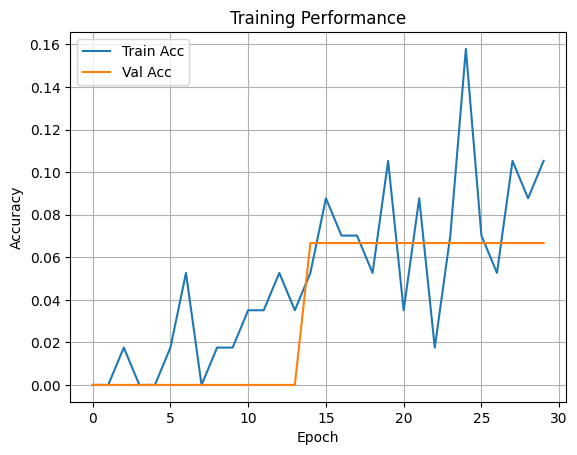

In [7]:
# ===== OPTIONAL: PLOT TRAINING =====
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Performance')
plt.grid()
plt.show()

In [18]:
# ===== ADVANCED MLP MODEL FOR AUDIO FEATURES =====

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization


In [19]:
# Reshape input for MLP: (N, 64, 1) → (N, 64)
X_train_mlp = X_train.reshape(X_train.shape[0], -1)
X_test_mlp = X_test.reshape(X_test.shape[0], -1)

# Clear previous session
K.clear_session()

mlp_model = Sequential()

In [20]:
# ===== INPUT LAYER =====
mlp_model.add(Input(shape=(64,)))

# ===== DEEP FULLY CONNECTED BLOCKS =====
mlp_model.add(Dense(1024, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.5))

mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.4))

mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.3))

mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dropout(0.2))

# ===== OUTPUT LAYER =====
mlp_model.add(Dense(y.shape[1], activation='softmax'))

# ===== COMPILE =====
mlp_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 156)            │        20,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 782,876 (2.99 MB)

 Trainable params: 779,292 (2.97 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [21]:
# ===== CALLBACKS =====
mlp_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)
]

# ===== TRAIN MLP MODEL =====
mlp_history = mlp_model.fit(
    X_train_mlp, y_train,
    validation_data=(X_test_mlp, y_test),
    epochs=30,
    batch_size=32,
    callbacks=mlp_callbacks
)

Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.1326 - loss: 3.7882 - val_accuracy: 0.2423 - val_loss: 2.7033 - learning_rate: 1.0000e-04
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1998 - loss: 2.8776 - val_accuracy: 0.2573 - val_loss: 2.6294 - learning_rate: 1.0000e-04
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2212 - loss: 2.7551 - val_accuracy: 0.2641 - val_loss: 2.5911 - learning_rate: 1.0000e-04
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2327 - loss: 2.7040 - val_accuracy: 0.2670 - val_loss: 2.5583 - learning_rate: 1.0000e-04
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2410 - loss: 2.6773 - val_accuracy: 0.2731 - val_loss: 2.5273 - learning_rate: 1.0000e-04
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2468 - loss: 2.6387 - val_accuracy: 0.2799 - val_loss: 2.5034 - learning_rate: 1.0000e-04
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 

In [22]:
# ===== EVALUATION =====
y_pred_probs_mlp = mlp_model.predict(X_test_mlp)
y_pred_mlp = np.argmax(y_pred_probs_mlp, axis=1)
y_true_mlp = np.argmax(y_test, axis=1)

print("\nMLP Classification Report:\n", classification_report(y_true_mlp, y_pred_mlp))
print("\nMLP Confusion Matrix:\n", confusion_matrix(y_true_mlp, y_pred_mlp))

# ===== SAVE MLP MODEL =====
mlp_model.save("mlp_out_of_tune_model.h5")


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


MLP Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        23
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00        19
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00        21
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        1

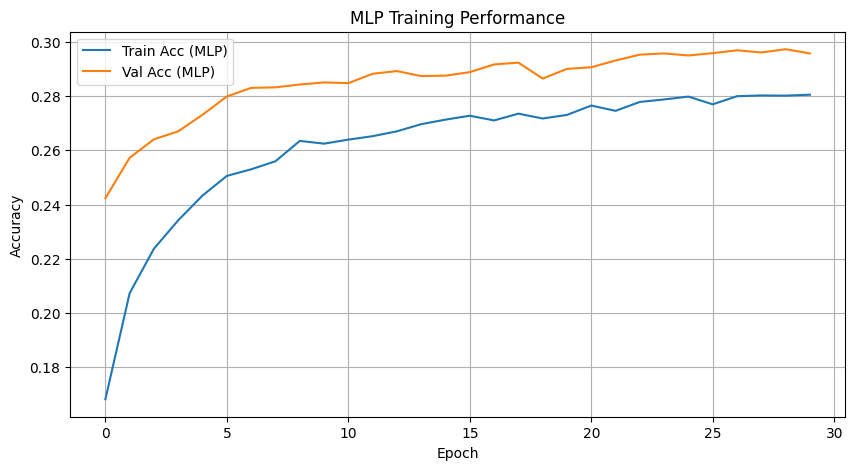

In [23]:
# ===== OPTIONAL: PLOT MLP TRAINING =====
plt.figure(figsize=(10,5))
plt.plot(mlp_history.history['accuracy'], label='Train Acc (MLP)')
plt.plot(mlp_history.history['val_accuracy'], label='Val Acc (MLP)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MLP Training Performance')
plt.grid()
plt.show()
